(basic-demo)=
# Feature store example (stocks)

This notebook demonstrates the following:
- Generate features and feature-sets
- Build complex transformations and ingest to offline and real-time data stores
- Fetch feature vectors for training
- Save feature vectors for re-use in real-time pipelines
- Access features and their statistics in real-time

```{admonition} Note
By default, this demo works with the online feature store, which is currently not part of the Open Source MLRun default deployment.
```

**In this section**
- [Get started](#get-started)
- [Create sample data for demo](#create-sample-data-for-demo)
- [Define, infer and ingest feature sets](#define-infer-and-ingest-feature-sets)
- [Get an offline feature vector for training](#get-an-offline-feature-vector-for-training)
- [Initialize an online feature service and use it for real-time inference](#initialize-an-online-feature-service-and-use-it-for-real-time-inference)

## Get started

Install the latest MLRun package and restart the notebook.

Setting up the environment and project:

In [1]:
import mlrun

mlrun.get_or_create_project("stocks", "./")

> 2024-09-11 12:37:21,186 [info] Server and client versions are not the same but compatible: {'parsed_server_version': Version(major=1, minor=7, patch=0, prerelease='rc40', build=None), 'parsed_client_version': Version(major=1, minor=6, patch=3, prerelease=None, build=None)}
> 2024-09-11 12:37:21,273 [info] Project loaded successfully: {'project_name': 'stocks'}


## Create sample data for demo

In [2]:
import pandas as pd

quotes = pd.DataFrame(
    {
        "time": [
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.030"),
            pd.Timestamp("2016-05-25 13:30:00.041"),
            pd.Timestamp("2016-05-25 13:30:00.048"),
            pd.Timestamp("2016-05-25 13:30:00.049"),
            pd.Timestamp("2016-05-25 13:30:00.072"),
            pd.Timestamp("2016-05-25 13:30:00.075"),
        ],
        "ticker": ["GOOG", "MSFT", "MSFT", "MSFT", "GOOG", "AAPL", "GOOG", "MSFT"],
        "bid": [720.50, 51.95, 51.97, 51.99, 720.50, 97.99, 720.50, 52.01],
        "ask": [720.93, 51.96, 51.98, 52.00, 720.93, 98.01, 720.88, 52.03],
    }
)

trades = pd.DataFrame(
    {
        "time": [
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.038"),
            pd.Timestamp("2016-05-25 13:30:00.048"),
            pd.Timestamp("2016-05-25 13:30:00.048"),
            pd.Timestamp("2016-05-25 13:30:00.048"),
        ],
        "ticker": ["MSFT", "MSFT", "GOOG", "GOOG", "AAPL"],
        "price": [51.95, 51.95, 720.77, 720.92, 98.0],
        "quantity": [75, 155, 100, 100, 100],
    }
)


stocks = pd.DataFrame(
    {
        "ticker": ["MSFT", "GOOG", "AAPL"],
        "name": ["Microsoft Corporation", "Alphabet Inc", "Apple Inc"],
        "exchange": ["NASDAQ", "NASDAQ", "NASDAQ"],
    }
)

import datetime


def move_date(df, col):
    max_date = df[col].max()
    now_date = datetime.datetime.now()
    delta = now_date - max_date
    df[col] = df[col] + delta
    return df


quotes = move_date(quotes, "time")
trades = move_date(trades, "time")

### View the demo data

In [3]:
quotes

,time,ticker,bid,ask
0,2024-09-11 12:37:21.246888,GOOG,720.50,720.93
1,2024-09-11 12:37:21.246888,MSFT,51.95,51.96
2,2024-09-11 12:37:21.253888,MSFT,51.97,51.98
3,2024-09-11 12:37:21.264888,MSFT,51.99,52.00
4,2024-09-11 12:37:21.271888,GOOG,720.50,720.93
5,2024-09-11 12:37:21.272888,AAPL,97.99,98.01
6,2024-09-11 12:37:21.295888,GOOG,720.50,720.88
7,2024-09-11 12:37:21.298888,MSFT,52.01,52.03


In [4]:
trades

,time,ticker,price,quantity
0,2024-09-11 12:37:21.275001,MSFT,51.95,75
1,2024-09-11 12:37:21.290001,MSFT,51.95,155
2,2024-09-11 12:37:21.300001,GOOG,720.77,100
3,2024-09-11 12:37:21.300001,GOOG,720.92,100
4,2024-09-11 12:37:21.300001,AAPL,98.00,100


In [5]:
stocks

,ticker,name,exchange
0,MSFT,Microsoft Corporation,NASDAQ
1,GOOG,Alphabet Inc,NASDAQ
2,AAPL,Apple Inc,NASDAQ


## Define, infer and ingest feature sets

In [6]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import *
from mlrun.features import MinMaxValidator

### Build and ingest simple feature set (stocks)

In [7]:
# add feature set without time column (stock ticker metadata)
stocks_set = fstore.FeatureSet("stocks", entities=[fstore.Entity("ticker")])
fstore.ingest(stocks_set, stocks, infer_options=fstore.InferOptions.default())

,name,exchange
ticker,,
MSFT,Microsoft Corporation,NASDAQ
GOOG,Alphabet Inc,NASDAQ
AAPL,Apple Inc,NASDAQ


### Build an advanced feature set - with feature engineering pipeline
Define a feature set with custom data processing and time aggregation functions:

In [8]:
# create a new feature set
quotes_set = fstore.FeatureSet(
    "stock-quotes", entities=[fstore.Entity("ticker")], timestamp_key="time"
)

**Define a custom pipeline step (python class)**

In [9]:
class MyMap(MapClass):
    def __init__(self, multiplier=1, **kwargs):
        super().__init__(**kwargs)
        self._multiplier = multiplier

    def do(self, event):
        event["multi"] = event["bid"] * self._multiplier
        return event

**Build and show the transformation pipeline**

Use `storey` stream processing classes along with library and custom classes:

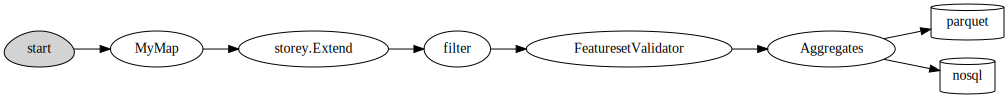

In [10]:
quotes_set.graph.to("MyMap", multiplier=3).to(
    "storey.Extend", _fn="({'extra': event['bid'] * 77})"
).to("storey.Filter", "filter", _fn="(event['bid'] > 51.92)").to(FeaturesetValidator())

quotes_set.add_aggregation("ask", ["sum", "max"], "1h", "10m", name="asks1")
quotes_set.add_aggregation("ask", ["sum", "max"], "5h", "10m", name="asks5")
quotes_set.add_aggregation("bid", ["min", "max"], "1h", "10m", name="bids")

# add feature validation policy
quotes_set["bid"] = fstore.Feature(validator=MinMaxValidator(min=52, severity="info"))

# add default target definitions and plot
quotes_set.set_targets()
quotes_set.plot(rankdir="LR", with_targets=True)

**Test and show the pipeline results locally (allow to quickly develop and debug)**

In [11]:
quotes_set.preview(
    quotes,
    entity_columns=["ticker"],
    options=fstore.InferOptions.default(),
)

info! bid value is smaller than min, key=['MSFT'] args={'min': 52, 'value': '51.95'}
info! bid value is smaller than min, key=['MSFT'] args={'min': 52, 'value': '51.97'}
info! bid value is smaller than min, key=['MSFT'] args={'min': 52, 'value': '51.99'}


,asks1_sum_1h,asks1_max_1h,asks5_sum_5h,asks5_max_5h,bids_min_1h,bids_max_1h,time,bid,ask,multi,extra
ticker,,,,,,,,,,,
GOOG,720.93,720.93,720.93,720.93,720.50,720.50,2024-09-11 12:37:21.246888,720.50,720.93,2161.50,55478.50
MSFT,51.96,51.96,51.96,51.96,51.95,51.95,2024-09-11 12:37:21.246888,51.95,51.96,155.85,4000.15
MSFT,103.94,51.98,103.94,51.98,51.95,51.97,2024-09-11 12:37:21.253888,51.97,51.98,155.91,4001.69
MSFT,155.94,52.00,155.94,52.00,51.95,51.99,2024-09-11 12:37:21.264888,51.99,52.00,155.97,4003.23
GOOG,1441.86,720.93,1441.86,720.93,720.50,720.50,2024-09-11 12:37:21.271888,720.50,720.93,2161.50,55478.50
AAPL,98.01,98.01,98.01,98.01,97.99,97.99,2024-09-11 12:37:21.272888,97.99,98.01,293.97,7545.23
GOOG,2162.74,720.93,2162.74,720.93,720.50,720.50,2024-09-11 12:37:21.295888,720.50,720.88,2161.50,55478.50
MSFT,207.97,52.03,207.97,52.03,51.95,52.01,2024-09-11 12:37:21.298888,52.01,52.03,156.03,4004.77


In [12]:
# print the feature set object
print(quotes_set.to_yaml())

kind: FeatureSet
metadata:
  name: stock-quotes
  project: stocks
spec:
  entities:
  - name: ticker
    value_type: str
  features:
  - name: asks1_sum_1h
    value_type: float
    aggregate: true
  - name: asks1_max_1h
    value_type: float
    aggregate: true
  - name: asks5_sum_5h
    value_type: float
    aggregate: true
  - name: asks5_max_5h
    value_type: float
    aggregate: true
  - name: bids_min_1h
    value_type: float
    aggregate: true
  - name: bids_max_1h
    value_type: float
    aggregate: true
  - name: bid
    value_type: float
    validator:
      kind: minmax
      severity: info
      min: 52
  - name: ask
    value_type: float
  - name: multi
    value_type: float
  - name: extra
    value_type: float
  partition_keys: []
  timestamp_key: time
  targets:
  - name: parquet
    kind: parquet
    partitioned: true
  - name: nosql
    kind: nosql
    partitioned: false
  graph:
    steps:
      MyMap:
        kind: task
        class_name: MyMap
        class_arg

### Ingest data into offline and online stores
This writes to both targets (Parquet and NoSQL).

In [13]:
# save ingest data and print the FeatureSet spec
df = quotes_set.ingest(quotes)

info! bid value is smaller than min, key=['MSFT'] args={'min': 52, 'value': '51.95'}
info! bid value is smaller than min, key=['MSFT'] args={'min': 52, 'value': '51.97'}
info! bid value is smaller than min, key=['MSFT'] args={'min': 52, 'value': '51.99'}
info! bid value is smaller than min, key=['MSFT'] args={'min': 52, 'value': '51.95'}
info! bid value is smaller than min, key=['MSFT'] args={'min': 52, 'value': '51.97'}
info! bid value is smaller than min, key=['MSFT'] args={'min': 52, 'value': '51.99'}


## Get an offline feature vector for training
Example of combining features from 3 sources with time travel join of 3 tables with **time travel**.

Specify a set of features and request the feature vector offline result as a dataframe:

In [14]:
features = [
    "stock-quotes.multi",
    "stock-quotes.asks5_sum_5h as total_ask",
    "stock-quotes.bids_min_1h",
    "stock-quotes.bids_max_1h",
    "stocks.*",
]

vector = fstore.FeatureVector(
    "stocks-vec", features, description="stocks demo feature vector"
)
vector.save()

In [15]:
resp = vector.get_offline_features(entity_rows=trades, entity_timestamp_column="time")
resp.to_dataframe()

> 2024-09-11 12:37:23,529 [info] Merger detected timestamp resolution incompatibility between feature set stock-quotes and others: datetime64[ns] and datetime64[us]. Converting feature set timestamp column 'time' to type datetime64[ns].


,price,quantity,multi,total_ask,bids_min_1h,bids_max_1h,name,exchange
0,51.95,75,155.97,155.94,51.95,51.99,Microsoft Corporation,NASDAQ
1,51.95,155,155.97,155.94,51.95,51.99,Microsoft Corporation,NASDAQ
2,720.77,100,2161.50,2162.74,720.50,720.50,Alphabet Inc,NASDAQ
3,720.92,100,2161.50,2162.74,720.50,720.50,Alphabet Inc,NASDAQ
4,98.00,100,293.97,98.01,97.99,97.99,Apple Inc,NASDAQ


## Initialize an online feature service and use it for real-time inference

In [19]:
service = vector.get_online_feature_service("")

**Request feature vector statistics, can be used for imputing or validation**

In [20]:
service.vector.get_stats_table()

,count,mean,min,25%,50%,75%,max,std,hist,unique,top,freq
multi,8.0,925.27875,155.85,155.9550,225.000,2161.5000,2161.50,1024.751408,"[[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,NaN,NaN
bids_min_1h,8.0,308.41125,51.95,51.9500,74.970,720.5000,720.50,341.596673,"[[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,NaN,NaN
bids_max_1h,8.0,308.42625,51.95,51.9850,75.000,720.5000,720.50,341.583803,"[[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,NaN,NaN
name,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Microsoft Corporation,1.0
exchange,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NASDAQ,3.0
total_ask,8.0,617.91875,51.96,102.4575,181.955,901.1625,2162.74,784.877980,"[[4, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,...",NaN,NaN,NaN


**Real-time feature vector request**

In [21]:
service.get([{"ticker": "GOOG"}, {"ticker": "MSFT"}])

[{'bids_min_1h': 720.5,
  'bids_max_1h': 720.5,
  'total_ask': 2162.74,
  'multi': 2161.5,
  'name': 'Alphabet Inc',
  'exchange': 'NASDAQ'},
 {'bids_min_1h': 51.95,
  'bids_max_1h': 52.01,
  'total_ask': 207.97,
  'multi': 156.03,
  'name': 'Microsoft Corporation',
  'exchange': 'NASDAQ'}]

In [22]:
service.get([{"ticker": "AAPL"}])

[{'bids_min_1h': 97.99,
  'bids_max_1h': 97.99,
  'total_ask': 98.01,
  'multi': 293.97,
  'name': 'Apple Inc',
  'exchange': 'NASDAQ'}]

In [23]:
service.close()